Reference: https://www.kaggle.com/code/yamanizm/recommendation-systems-svd-hybrid-k-nn-kmeans

# Submission 2 MLT - Sistem Rekomendasi Anime
https://www.dicoding.com/users/atthaariq

## Load Dataset
Download *dataset* dari *kaggle* dengan opendatasets.

In [1]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv')
od.download('https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=anime.csv')

Skipping, found downloaded files in ".\anime-recommendations-database" (use force=True to force download)
Skipping, found downloaded files in ".\anime-recommendations-database" (use force=True to force download)


**_Dataset_ yang digunakan adalah sebagai berikut:**
- `anime` yang berisi informasi anime, dipakai untuk target rekomendasi
- `rating` yang berisi informasi *rating* anime oleh pengguna, dipakai sebagai data yang dilatih.

In [2]:
import pandas as pd
anime = pd.read_csv('anime-recommendations-database/anime.csv')
rating = pd.read_csv('anime-recommendations-database/rating.csv')

Melihat 5 data teratas dari *dataset* anime dan rating.

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [17]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Kita dapat melihat 5 data teratas dari *dataset* anime & rating yang berarti *dataset* ini berhasil di-*load*.

In [4]:
anime[anime.name=='Pokemon']

,anime_id,name,genre,type,episodes,rating,members
1834,527,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,276,7.43,229157


In [5]:
rating[rating.anime_id==400]

,user_id,anime_id,rating
2486,23,400,10
8855,109,400,7
17385,226,400,7
19932,247,400,8
22139,270,400,-1
...,...,...,...
7804019,73408,400,9
7807317,73443,400,10
7808044,73457,400,9
7810685,73491,400,-1


## Data Understanding & Analysis

Pertama, melihat berapa banyak kolom dan baris (variabel & data).

In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [7]:
print(f'anime shape: {anime.shape}\nrating shape: {rating.shape}')

anime shape: (12294, 7)
rating shape: (7813737, 3)


- `anime` memiliki 7 kolom data dan 12,294 baris.
- `rating` memiliki 3 kolom data dan 7,813,737 baris.

In [8]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Terdapat 3 kolom numerik pada *dataset* `anime`, yaitu 2 kolom numerik diskrit yaitu `anime_id` & `members`, serta kolom numerik kontinyu yaitu `rating`.

In [9]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Semua kolom *dataset* `rating` adalah data numerik diskrit.

Kemudian cek apakah ada *missing values* / null pada kedua *dataset*.

In [10]:
rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [11]:
anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

*Dataset* anime memiliki nilai null pada 3 kolom, dengan null terbanyak pada kolom `rating` (230 data).

Semua baris data yang memiliki nilai null pada kolom datanya akan di-*drop*.

In [12]:
anime.dropna(axis = 0, inplace = True)
anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [13]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


Tidak ada lagi null pada *dataset* `anime`. Jumlah baris data menjadi 12017.

In [14]:
anime.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


Melihat keragaman data pada *dataset* `anime` & `rating`.

In [15]:
anime.nunique()

anime_id    12017
name        12015
genre        3229
type            6
episodes      187
rating        598
members      6596
dtype: int64

In [16]:
rating.nunique()

user_id     73515
anime_id    11200
rating         11
dtype: int64

Impor *library* untuk keperluan visualisasi data.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Melihat korelasi antar kolom kedua *dataset* dengan *heatmap*.

<AxesSubplot:title={'center':'Heatmap korelasi dataset anime'}>

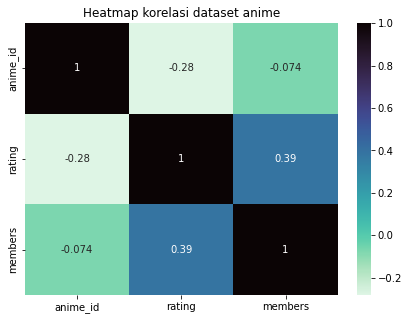

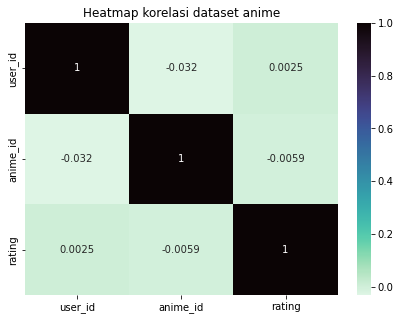

In [18]:
plt.figure(figsize=(7,5))
plt.title("Heatmap korelasi dataset anime")
sns.heatmap(anime.corr(),annot = True,cmap = 'mako_r')
plt.figure(figsize=(7,5))
plt.title("Heatmap korelasi dataset anime")
sns.heatmap(rating.corr(),annot = True,cmap = 'mako_r')

Mengecek duplikasi kolom pada kedua tabel.

In [19]:
print(anime[anime.duplicated()].shape)
print(rating[rating.duplicated()].shape)

(0, 7)
(1, 3)


Terdapat duplikasi pada `rating`, kita hapus dengan `drop_duplicated`.

In [20]:
rating.drop_duplicates(keep='first',inplace=True)
rating[rating.duplicated()].shape

(0, 3)

## Create Dataset for Recommender System

*Dataset* untuk *training* didapatkan dari menggabungkan *dataset* `anime` dan `rating`.

In [22]:
df = pd.merge(anime,rating, on='anime_id')
df.head(5)

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [23]:
df.describe()

,anime_id,rating_x,members,user_id,rating_y
count,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06,7.813610e+06
mean,8.908728e+03,7.653158e+00,1.786233e+05,3.672799e+04,6.144075e+00
std,8.883598e+03,6.729753e-01,1.881764e+05,2.099793e+04,3.727792e+00
min,1.000000e+00,1.670000e+00,2.900000e+01,1.000000e+00,-1.000000e+00
25%,1.240000e+03,7.270000e+00,4.403000e+04,1.897400e+04,6.000000e+00
50%,6.213000e+03,7.680000e+00,1.104700e+05,3.679100e+04,7.000000e+00
75%,1.409300e+04,8.130000e+00,2.442680e+05,5.475800e+04,9.000000e+00
max,3.451900e+04,9.500000e+00,1.013917e+06,7.351600e+04,1.000000e+01


Data rating yang akan dipakai adalah `rating_x` karena `rating_y` memiliki data dengan nilai -1. `rating_x` diubah menjadi `user_rating`.

In [24]:
df = df.rename(columns={"rating_x": "user_rating"})
df = df.drop('rating_y', axis=1)

## Data Preparation 

### Handling Missing Value
Mengecek nilai Null pada `df`.

In [26]:
df = df.copy()
df = df.dropna(axis = 0)
print("Nilai null:")
df.isna().sum()

Nilai null:


anime_id       0
name           0
genre          0
type           0
episodes       0
user_rating    0
members        0
user_id        0
dtype: int64

### Cleaning Text
Sebuah *Function* untuk:
- Mengubah teks menjadi *lowercase*
- Menghapus simbol dan *special characters*

In [28]:
import re
import string

def clean_text(text):
    # to lowercase
    text = text.lower()

    # remove sybmols and other words
    text = re.sub(r'<[^>]*>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
  
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

*Cleaning* pada data `'name'` di *dataset* `df` dan `anime`.

In [29]:
import time

start = time.time()
df['name']=df['name'].apply(clean_text)
end = time.time()
print("Preprocessing df['name']: ", end-start, " sec.")

start = time.time()
anime['name'] = anime['name'].apply(clean_text)
end = time.time()
print("Preprocessing anime['name']: ", end-start, " sec.")

Preprocessing df['name']:  81.81658864021301  sec.
Preprocessing anime['name']:  0.13961291313171387  sec.


## Modelling
### Popularity-based
*Function* untuk rekomendasi dengan *popularity-based* melakukan grouping berdasarkan input fitur nanti dengan `groupby()` dan menghitung *mean* dari rating penontonnya.

Kemudian hasil tersebut diurutkan dan dan ditampilkan dengan 10 hasil teratas.

In [30]:
def popularity_recommender(df, selected_features):

    # grouping & menghitung rata-rata rating pengguna
    grouped_df = df.groupby(selected_features).agg({'user_rating': 'mean'}).reset_index()
    # mengurutkan berdasarkan rating
    sorted_df = grouped_df.sort_values('user_rating', ascending=False)
    # menampilkan 10 hasil teratas yang diurutkan
    recommendations = sorted_df.head(10)
    return recommendations

In [31]:
df.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'user_rating',
       'members', 'user_id'],
      dtype='object')

Rating berdasarkan judul anime:

In [32]:
# berdasarkan judul
selected_features = ['name']
popularity_recommender(df, selected_features)

,name,user_rating
6469,mogura no motoro,9.50
4919,kimi no na wa,9.37
2582,fullmetal alchemist brotherhood,9.26
3033,gintama°,9.25
10764,yakusoku africa mizu to midori,9.25
9318,steinsgate,9.17
3292,haikyuu karasuno koukou vs shiratorizawa gakue...,9.15
3919,hunter x hunter 2011,9.13
2972,ginga eiyuu densetsu,9.11
3023,gintama enchousen,9.11


Rating berdasarkan 10 judul dengan penonton terbanyak:

In [33]:
# berdasarkan 10 judul terpopuler
selected_features = ['members']
popularity_recommender(df, selected_features)

,members,user_rating
6268,200630,9.37
6479,793665,9.26
6016,114262,9.25
6475,673572,9.17
6152,151266,9.16
5879,93351,9.15
6440,425855,9.13
5760,80679,9.11
5768,81109,9.11
5680,72534,9.10


Rating berdasarkan genre terpopuler. Genre yang dipakai hanya genre urutan pertama / *first genre*.

In [34]:
# membuat kolom first genre
df['first_genre'] = df['genre'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

# rekom berdasarkan first genre
selected_features = ['first_genre']
popularity_recommender(df, selected_features)

,first_genre,user_rating
14,Josei,8.463213
28,Sci-Fi,8.352921
24,Psychological,8.210347
21,Mystery,8.199439
4,Dementia,7.831614
6,Drama,7.791295
9,Game,7.741392
0,Action,7.715880
1,Adventure,7.676925
2,Cars,7.661395


Rating berdasarkan jenis / tipe anime:

In [35]:
#berdasarkan tipe
selected_features = ['type']
popularity_recommender(df, selected_features)

,type,user_rating
0,Movie,7.809518
5,TV,7.738967
4,Special,7.330543
3,OVA,7.196094
2,ONA,7.053085
1,Music,7.032784


### Title-based Recommender
- **a. Clustering + Collaborative Filtering**
- **b. Clustering + Content-based Filtering**

Terdapat dua pendekatan pada sistem rekomendasi berdasarkan judul yang sedang ditonton. Masing-masing pendekatan akan menggunakan klasterisasi dahulu.

#### 1. Clustering (K-Means)

- *Label encoding* pada data 'genre' dan 'type' di `df`.
- Model K-Means dengan parameter:
    - n_clusters: 6
    - random_state: 42
- Kemudian *fit* model pada data 'anime_id', 't_genre', 't_type', dan 'user_rating' di `df`.

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

#encoding
le = LabelEncoder()

start = time.time()
df['t_genre']= le.fit_transform(df['genre'])
df['t_type']= le.fit_transform(df['type'])
end = time.time()
print("Label encoding :", end-start, " sec.")

selected_features = ['anime_id','t_genre','t_type', 'user_rating']
 
# k-means model
kmeans = KMeans(n_clusters=6, random_state=42)

start = time.time()
df['cluster'] = kmeans.fit_predict(df[selected_features])
end = time.time()
print("K-Means fit:", end-start, " sec.")

Label encoding : 2.8743717670440674  sec.


C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means fit: 45.05245590209961  sec.


In [42]:
from collections import Counter

labels = kmeans.labels_

# hitung elemen pada tiap klaster
cluster_counts = Counter(labels)

for cluster_id, count in cluster_counts.items():
    print(f"Klaster {cluster_id}: {count} elemen")

Klaster 3: 520020 elemen
Klaster 0: 1437374 elemen
Klaster 2: 1353337 elemen
Klaster 4: 2952323 elemen
Klaster 5: 844242 elemen
Klaster 1: 706314 elemen


#### 2. Set random user & anime title to recommend

Memilih pengguna dan 1 judul anime yang telah ditonton pengguna tersebut secara random untuk diberikan rekomendaasi anime yang mirip. 

- Memilih klaster random dan user di dalam klaster tersebut secara random dengan `randint()` pada `const_cluster_no`
- Membuat pivot table berdasarkan klaster terpilih dengan nilai rating dengan `pivot_table()`
- Memilih judul anime yang bakal diberikan rekomendasi secara random pada `query_no`

In [44]:
import random

# memilih klaster random dan user di dalam klaster tersebut secara random
const_member_index = random.randint(1, len(df))
const_cluster_no = df.cluster[const_member_index]
const_cluster_no

user_no = df.user_id[const_member_index]

# membuat pivot table berdasarkan klaster terpilih dengan nilai rating
df_pivot = df[df.cluster == const_cluster_no].pivot_table(index="name", columns="user_id", values="user_rating").fillna(0)


In [49]:
# memilih judul anime yang bakal diberikan rekomendasi secara random
query_no = np.random.choice(df_pivot.shape[0]) 
print(f"Judul anime terpilih untuk diberikan rekomendasi:\nKueri: {query_no}\nJudul: {df_pivot.index[query_no]} ")
anime_const = df_pivot.index[query_no]

Judul anime terpilih untuk diberikan rekomendasi:
Kueri: 2810
Judul: yoroiden samurai troopers kikoutei densetsu 


#### A. Collaborative Filtering (KNN)
- Membuat Matriks *Compressed Sparse Row* (CSR) pada `df_pivot` dengan scipy `csr_matrix`
- Membuat model dengan scikit learn `NearestNeighbors()` yang memiliki parameter:
    - metric: "cosine"
    - algorithm: "auto"
- Kemudian *fit* `df_matrix()` tadi dalam model KNN
- Jarak dan indeks tiap anime didefinisikan dengan `model_knn.kneighbors()`

Kemudian untuk membuat rekomendasinya:
- Isi list `no`, `name`, `distance`, `rating`, dan `genre` berdasarkan data jarak dan indeks, di mana untuk `rating` dan `genre` menggunakan `flatten()`

In [52]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# KNN
start = time.time()
df_matrix = csr_matrix(df_pivot.values)
model_knn = NearestNeighbors(metric="cosine", algorithm="auto")
model_knn.fit(df_matrix)

distances, indices = model_knn.kneighbors(df_pivot.iloc[query_no, :].values.reshape(1, -1), n_neighbors=11)

no = []
name = []
distance = []
rating = []
genre = []

# rekomendasi
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for '{df_pivot.index[query_no]}' viewers :\n")
    else:
        no.append(i)
        name.append(df_pivot.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])
        rating.append(*anime[anime["name"] == df_pivot.index[indices.flatten()[i]]]["rating"].values)
        genre.append(*anime[anime["name"] == df_pivot.index[indices.flatten()[i]]]["genre"].values)

        
dic = {"No": no, "Anime Name": name, "Rating": rating, "Genre": genre, "Similarity": distance[::-1]}
recommendation = pd.DataFrame(data=dic)
recommendation.set_index("No", inplace=True)
end = time.time()
print("Collaborative filtering :", end-start, " sec.")
recommendation.head(5)


Recommendations for 'yoroiden samurai troopers kikoutei densetsu' viewers :

Collaborative filtering : 6.410833358764648  sec.


,Anime Name,Rating,Genre,Similarity
No,,,,
1,yoroiden samurai troopers gaiden,6.86,"Adventure, Fantasy, Samurai, Shounen",0.860990
2,yoroiden samurai troopers message,6.13,"Adventure, Fantasy, Samurai, Shounen",0.859938
3,yoroiden samurai troopers,7.21,"Adventure, Samurai, Sci-Fi, Shounen",0.858342
4,doramichan minidora sos,6.49,"Fantasy, Kids",0.853984
5,doramichan a blue straw hat,5.28,"Fantasy, Kids",0.852685


#### Content-based Filtering (TF-IDF)

- Melihat nilai pada fitur penting tiap anime dengan TF-IDF `TfidfVectorizer()` dengan parameter `analyzer`: "word"
- Ambil data klaster tadi yang telah dipilih acak untuk dijadikan data rekomendasi `rec_data`
- fitur penting TF-IDF adalah genre
- *Fit* data genre tadi menjadi matriks 
- Menghitung kemiripan juga dengan *cosine similarity*
- Kemudian *drop* duplikasi data pada data indeks dengan `pd.Series()` & `drop_duplicates()`

Untuk membuat rekomendasinya:

Urutkan nilai TF-IDF (`cos_sim`) seluruh anime dengan `sorted()` berdasarkan jarak kemiripian fitur tertinggi dalam list `cos_scores` dengan judul anime yang akan diberikan rekomendasi

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

start = time.time()
# TF-IDF
tfv = TfidfVectorizer(analyzer="word")

# ambil data klaster yang terpilih
rec_data = df[df.cluster == const_cluster_no].copy()
rec_data.drop_duplicates(subset ="name", keep = "first", inplace = True)
rec_data.reset_index(drop = True, inplace = True)

# jadikan genre sebagai fitur tf-idf
genres = rec_data["name"].str.split(", | , | ,").astype(str)

# matriks tf-idf
tfv_matrix = tfv.fit_transform(genres)
 
# hitung kemiripan
cos_sim = cosine_similarity(tfv_matrix, tfv_matrix)

# drop duplikasi
rec_indices = pd.Series(rec_data.index, index = rec_data["name"]).drop_duplicates()

# function rekomendasi
def give_recommendation(title, cos_sim=cos_sim):
    idx = rec_indices[title]
    cos_scores = list(enumerate(cos_sim[idx]))
    cos_scores = sorted(cos_scores, key=lambda x: x[1], reverse=True)
    cos_scores = cos_scores[1:11]
    anime_indices = [i[0] for i in cos_scores]
    
    # isi data
    sim_scores = [i[1] for i in cos_scores]
    rec_dic = {
        "No": range(1, 11),
        "Anime Name": anime["name"].iloc[anime_indices].values,
        "Rating": anime["rating"].iloc[anime_indices].values,
        "Genre": anime["genre"].iloc[anime_indices].values,
        "Similarity Score": sim_scores,
    }
    dataframe = pd.DataFrame(data=rec_dic)
    dataframe.set_index("No", inplace=True)

    print(f"Recommendations for '{title}' viewers :\n")

    return dataframe

end = time.time()
print("Content-based filtering :", end-start, " sec.")

give_recommendation(anime_const).head()


Content-based filtering : 1.1220507621765137  sec.
Recommendations for 'yoroiden samurai troopers kikoutei densetsu' viewers :



,Anime Name,Rating,Genre,Similarity Score
No,,,,
1,mujin wakusei survive,7.72,"Action, Adventure, Fantasy, Sci-Fi, Slice of Life",0.782989
2,kamichu,7.51,"Comedy, Drama, Slice of Life, Supernatural",0.701465
3,detective conan ova 08 high school girl detect...,7.30,"Comedy, Mystery, Police, Shounen",0.647034
4,flcl,8.06,"Action, Comedy, Dementia, Mecha, Parody, Sci-Fi",0.403561
5,ginga densetsu weed,7.31,"Adventure, Drama, Shounen",0.344954
